In [15]:

# Cell 1: Imports & basic configuration


import os
import random
import math

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make runs reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)



# Base folder for this data collection session
SESSION_DIR = "session_auto_labels_01"

# Folder where your images are stored
# 👉 If your CSV has full paths already, this can stay as SESSION_DIR.
# 👉 If images are in a subfolder, e.g. "session_auto_labels_01/images",
#    change this to os.path.join(SESSION_DIR, "images")
IMAGE_DIR = SESSION_DIR   # or: os.path.join(SESSION_DIR, "images")

# CSV with labels
CSV_PATH = os.path.join(SESSION_DIR, "manual_label_clean.csv")

# Train/validation split
VAL_SIZE = 0.2

# Data loading
BATCH_SIZE = 32
NUM_WORKERS = 2    # 0 if you get issues on Windows

# Training
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

# Image size (we resize all images to the same size)
IMG_HEIGHT = 66   # similar to PilotNet but simplified
IMG_WIDTH = 200

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [16]:

# Cell 2: Load and inspect the labels


df = pd.read_csv(CSV_PATH)

print("First rows of the labels CSV:")
display(df.head())

print("\nColumns:", list(df.columns))
print("Number of samples:", len(df))

# ✅ Use the actual column names from your CSV
FILENAME_COL = "filename"
ANGLE_COL    = "angle_deg"

# Drop rows where filename or angle is missing
df = df.dropna(subset=[FILENAME_COL, ANGLE_COL]).reset_index(drop=True)
print("\nAfter dropping NaNs, number of samples:", len(df))

# Max absolute angle (used for normalization to [-1, 1])
max_abs_angle = df[ANGLE_COL].abs().max()
print("Max absolute angle in dataset:", max_abs_angle)


First rows of the labels CSV:


,filename,angle_deg
0,img_000014.jpg,20.000000
1,img_000015.jpg,30.000000
2,img_000013.jpg,26.260885
3,img_000016.jpg,24.171852
4,img_000017.jpg,-5.824528



Columns: ['filename', 'angle_deg']
Number of samples: 470

After dropping NaNs, number of samples: 470
Max absolute angle in dataset: 75.62333175273392


In [17]:

# Cell 3: Train / Validation split


train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=SEED,
    shuffle=True
)

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 376
Validation samples: 94


In [18]:

# Cell 4: Dataset class


from torchvision import transforms

# Define image transforms
# - Resize to fixed size
# - Convert to tensor
# - Normalize (here we just scale to [0,1] with ToTensor; 
#   optional: add mean/std normalization later if needed)
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),   # scales pixels to [0,1]
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

class LineFollowingDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, angle_col=ANGLE_COL, filename_col=FILENAME_COL, max_abs_angle=1.0):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.angle_col = angle_col
        self.filename_col = filename_col
        self.max_abs_angle = max_abs_angle  # used to normalize angles to [-1, 1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.image_dir, row[self.filename_col])
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # Steering angle in degrees (or whatever you used)
        angle = float(row[self.angle_col])

        # Normalize angle to [-1, 1]
        angle_norm = angle / self.max_abs_angle

        # Convert to tensor
        angle_tensor = torch.tensor([angle_norm], dtype=torch.float32)

        return image, angle_tensor


In [19]:

# Cell 5: Create DataLoaders

train_dataset = LineFollowingDataset(
    train_df,
    IMAGE_DIR,
    transform=train_transform,
    angle_col=ANGLE_COL,
    filename_col=FILENAME_COL,
    max_abs_angle=max_abs_angle
)

val_dataset = LineFollowingDataset(
    val_df,
    IMAGE_DIR,
    transform=val_transform,
    angle_col=ANGLE_COL,
    filename_col=FILENAME_COL,
    max_abs_angle=max_abs_angle
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print("Number of train batches:", len(train_loader))
print("Number of val batches:", len(val_loader))


Number of train batches: 12
Number of val batches: 3


In [20]:
¡
# Cell 6: Define a CNN regression model 

class CNNRegression(nn.Module):
    """
    Simple CNN regression model for steering angle prediction.
    Input: RGB image [3 x 66 x 200]
    Output: 1 value in [-1, 1] (normalized steering angle)
    """
    def __init__(self, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
        super(CNNRegression, self).__init__()

        self.conv = nn.Sequential(
            # Conv block 1
            nn.Conv2d(3, 24, kernel_size=5, stride=2),   # -> [24 x H1 x W1]
            nn.ReLU(),
            # Conv block 2
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            # Conv block 3
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            # Conv block 4
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            # Conv block 5
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # We don't want to calculate the flattened size by hand, 
        # so we run a dummy input through conv to get it.
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_height, img_width)
            conv_out = self.conv(dummy)
            self.flatten_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Tanh()   # ensures output is in [-1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc(x)
        return x

model = CNNRegression().to(DEVICE)
print(model)


CNNRegression(
  (conv): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1152, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=True)
    (9): Tanh()
  )
)


In [21]:

# Cell 7: Define loss function and optimizer


criterion = nn.MSELoss()  # regression: Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Using device:", DEVICE)


Using device: cuda


In [22]:

# Cell 8: Training & validation loop


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, angles in dataloader:
        images = images.to(device)
        angles = angles.to(device)

        optimizer.zero_grad()
        outputs = model(images)          # predicted normalized angle
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, angles in dataloader:
            images = images.to(device)
            angles = angles.to(device)

            outputs = model(images)
            loss = criterion(outputs, angles)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss = evaluate(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}]  "
          f"Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")


Epoch [1/20]  Train Loss: 0.306301  Val Loss: 0.259385
Epoch [2/20]  Train Loss: 0.303209  Val Loss: 0.256762
Epoch [3/20]  Train Loss: 0.292665  Val Loss: 0.262725
Epoch [4/20]  Train Loss: 0.292790  Val Loss: 0.256578
Epoch [5/20]  Train Loss: 0.289135  Val Loss: 0.255381
Epoch [6/20]  Train Loss: 0.289370  Val Loss: 0.261174
Epoch [7/20]  Train Loss: 0.292774  Val Loss: 0.251332
Epoch [8/20]  Train Loss: 0.256497  Val Loss: 0.212220
Epoch [9/20]  Train Loss: 0.136021  Val Loss: 0.102271
Epoch [10/20]  Train Loss: 0.080820  Val Loss: 0.050424
Epoch [11/20]  Train Loss: 0.050980  Val Loss: 0.018834
Epoch [12/20]  Train Loss: 0.030747  Val Loss: 0.013796
Epoch [13/20]  Train Loss: 0.023078  Val Loss: 0.014317
Epoch [14/20]  Train Loss: 0.021429  Val Loss: 0.010353
Epoch [15/20]  Train Loss: 0.017866  Val Loss: 0.010147
Epoch [16/20]  Train Loss: 0.015070  Val Loss: 0.007846
Epoch [17/20]  Train Loss: 0.017725  Val Loss: 0.009661
Epoch [18/20]  Train Loss: 0.014706  Val Loss: 0.007138
E

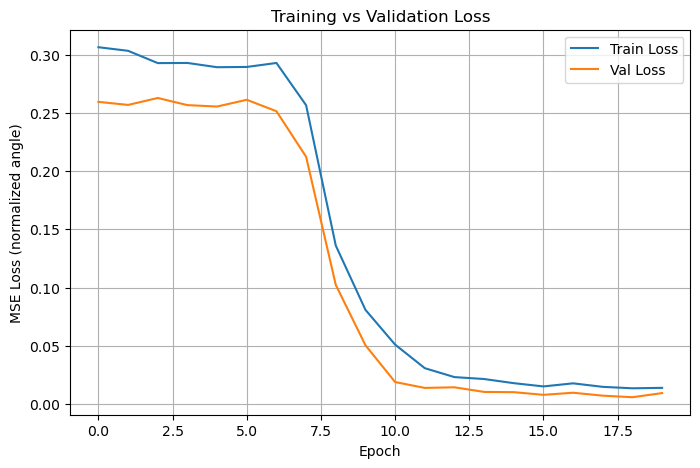

In [23]:

# Cell 9: Plot training & validation loss


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (normalized angle)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [24]:

# Cell 10: Evaluate on validation set (MAE in degrees)


model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for images, angles in val_loader:
        images = images.to(DEVICE)
        angles = angles.to(DEVICE)

        outputs = model(images)  # normalized
        # Denormalize back to original angle scale
        outputs_deg = outputs.cpu().numpy().flatten() * max_abs_angle
        angles_deg = angles.cpu().numpy().flatten() * max_abs_angle

        all_true.extend(angles_deg)
        all_pred.extend(outputs_deg)

all_true = np.array(all_true)
all_pred = np.array(all_pred)

mae = np.mean(np.abs(all_true - all_pred))
mse = np.mean((all_true - all_pred) ** 2)

print(f"Validation MAE (degrees): {mae:.3f}")
print(f"Validation MSE (degrees^2): {mse:.3f}")


Validation MAE (degrees): 5.350
Validation MSE (degrees^2): 53.429


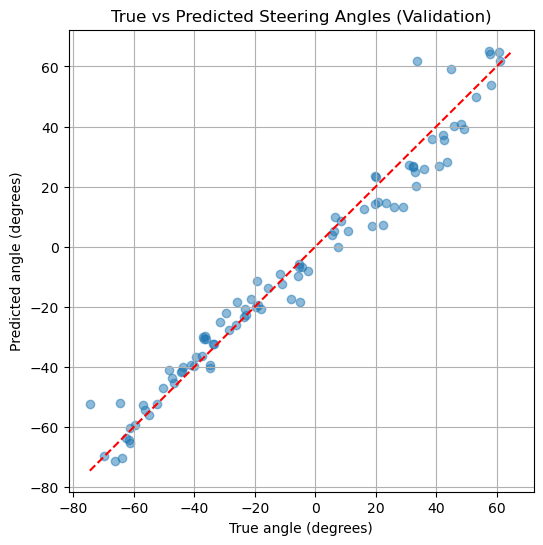

In [25]:

# Cell 11: Scatter plot: true vs predicted angles


plt.figure(figsize=(6, 6))
plt.scatter(all_true, all_pred, alpha=0.5)
min_val = min(all_true.min(), all_pred.min())
max_val = max(all_true.max(), all_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # perfect line
plt.xlabel("True angle (degrees)")
plt.ylabel("Predicted angle (degrees)")
plt.title("True vs Predicted Steering Angles (Validation)")
plt.grid(True)
plt.show()


Visualizing feature maps for: session_auto_labels_01/img_000309.jpg
Layer: conv1, activation shape: torch.Size([1, 24, 31, 98])


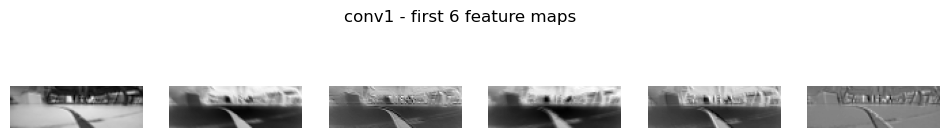

Layer: conv2, activation shape: torch.Size([1, 36, 14, 47])


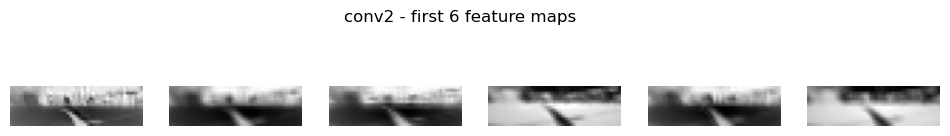

Layer: conv3, activation shape: torch.Size([1, 48, 5, 22])


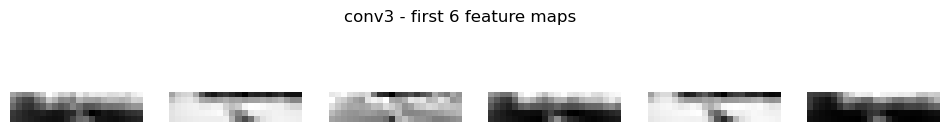

Layer: conv4, activation shape: torch.Size([1, 64, 3, 20])


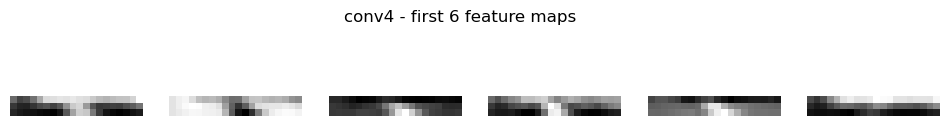

Layer: conv5, activation shape: torch.Size([1, 64, 1, 18])


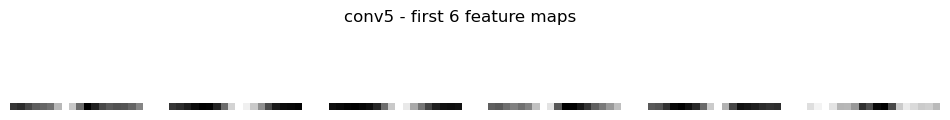

In [26]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch

# 1. Choose an image from your dataset
sample_row = val_df.sample(1).iloc[0]
img_path = os.path.join(IMAGE_DIR, sample_row[FILENAME_COL])
print("Visualizing feature maps for:", img_path)

# Use the same transform as your validation set
transform = val_transform   # already defined in your notebook

img_pil = Image.open(img_path).convert("RGB")
input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)  # [1,3,H,W]

# 2. Collect activations using forward hooks
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

# Indices of the Conv2d layers inside model.conv
conv_indices = [0, 2, 4, 6, 8]
conv_names   = ["conv1", "conv2", "conv3", "conv4", "conv5"]

for idx, name in zip(conv_indices, conv_names):
    model.conv[idx].register_forward_hook(get_activation(name))

# 3. Run a forward pass
model.eval()
with torch.no_grad():
    _ = model(input_tensor)

# 4. Plot some feature maps from each layer
def plot_feature_maps(act, layer_name, num_maps=6):
    # act shape: [1, C, H, W]
    act = act[0]  # remove batch dim -> [C, H, W]
    C = act.shape[0]
    num_maps = min(num_maps, C)

    plt.figure(figsize=(12, 2))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i+1)
        plt.imshow(act[i].numpy(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"{layer_name} - first {num_maps} feature maps")
    plt.show()

for layer_name in conv_names:
    print(f"Layer: {layer_name}, activation shape: {activations[layer_name].shape}")
    plot_feature_maps(activations[layer_name], layer_name, num_maps=6)


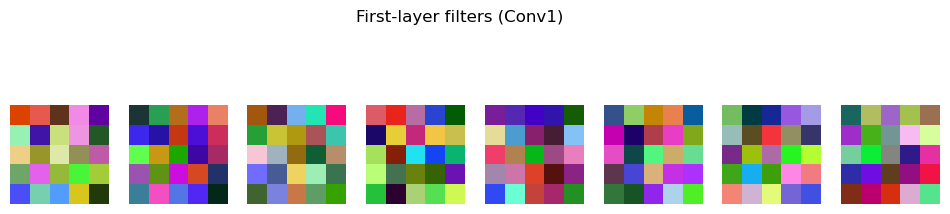

In [27]:
# Visualize Conv1 filters as images
conv1_weights = model.conv[0].weight.data.cpu()  # shape: [24, 3, 5, 5]

num_filters = conv1_weights.shape[0]
plt.figure(figsize=(12, 3))
for i in range(min(num_filters, 8)):  # show first 8
    w = conv1_weights[i]  # [3, 5, 5]
    # Normalize to [0,1] for display
    w_min, w_max = w.min(), w.max()
    w_norm = (w - w_min) / (w_max - w_min + 1e-5)
    w_img = w_norm.permute(1, 2, 0).numpy()  # [5,5,3] -> HWC
    plt.subplot(1, 8, i+1)
    plt.imshow(w_img)
    plt.axis("off")
plt.suptitle("First-layer filters (Conv1)")
plt.show()


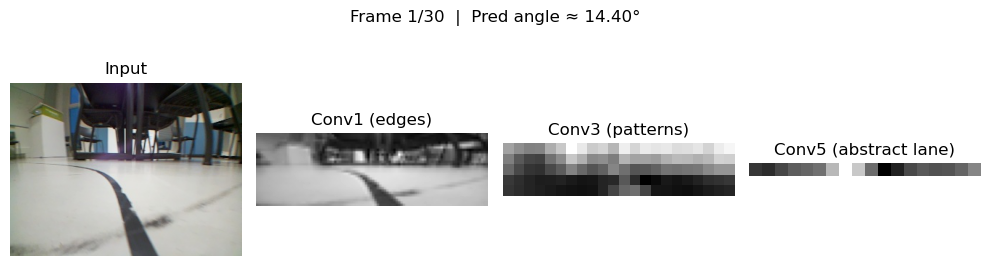

<Figure size 640x480 with 0 Axes>

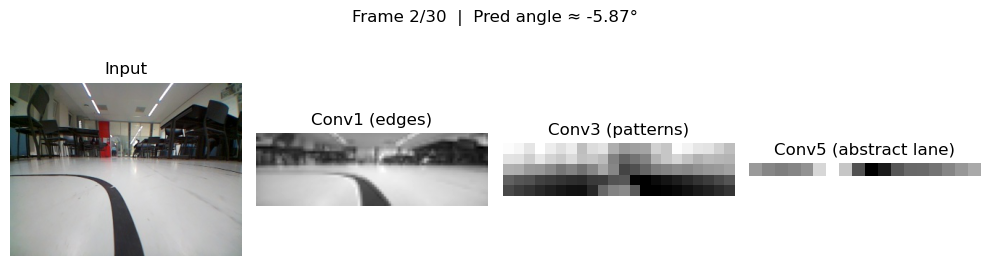

<Figure size 640x480 with 0 Axes>

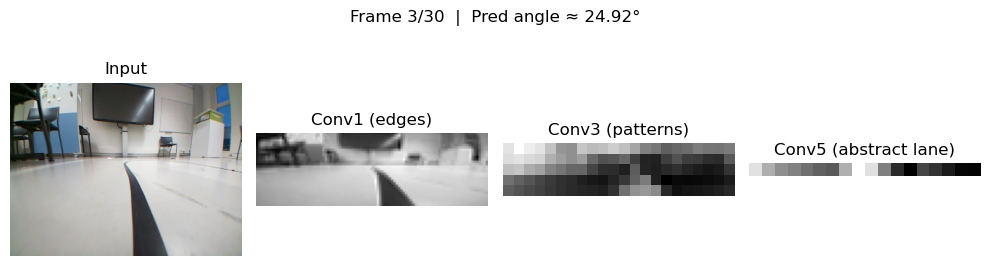

<Figure size 640x480 with 0 Axes>

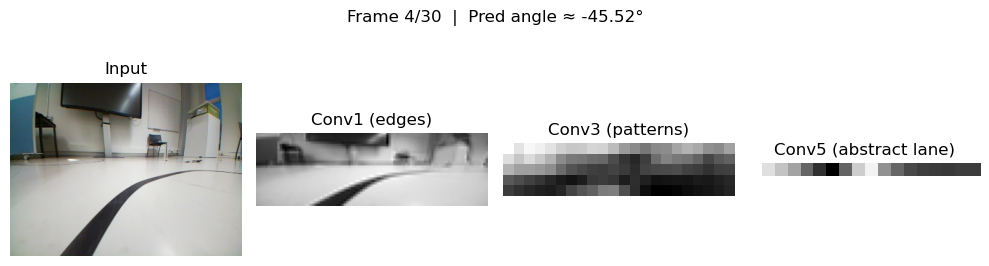

<Figure size 640x480 with 0 Axes>

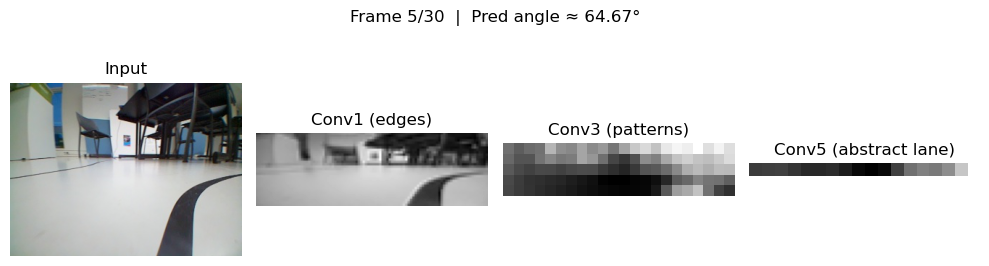

<Figure size 640x480 with 0 Axes>

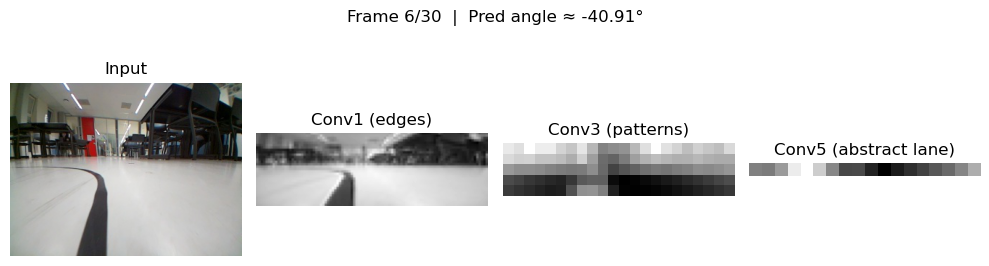

<Figure size 640x480 with 0 Axes>

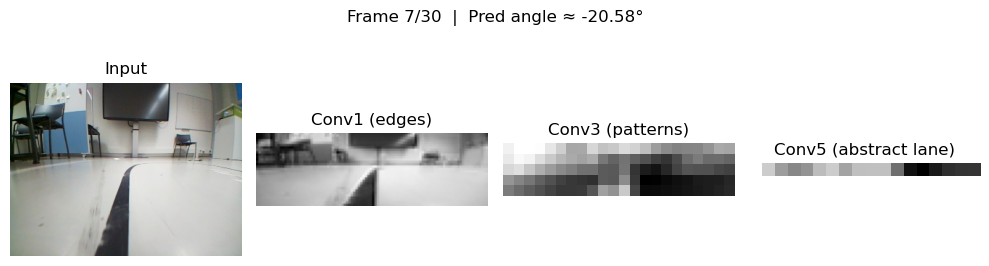

<Figure size 640x480 with 0 Axes>

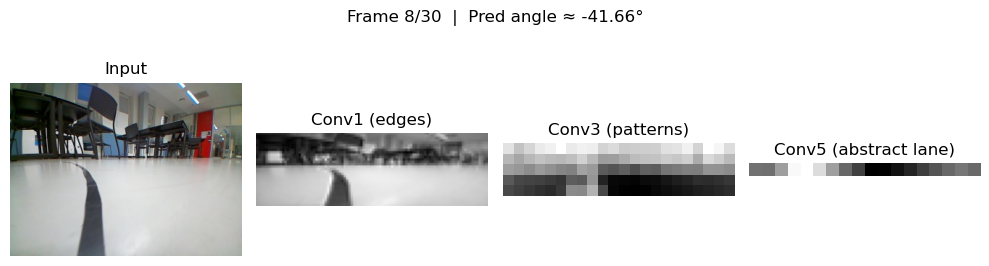

<Figure size 640x480 with 0 Axes>

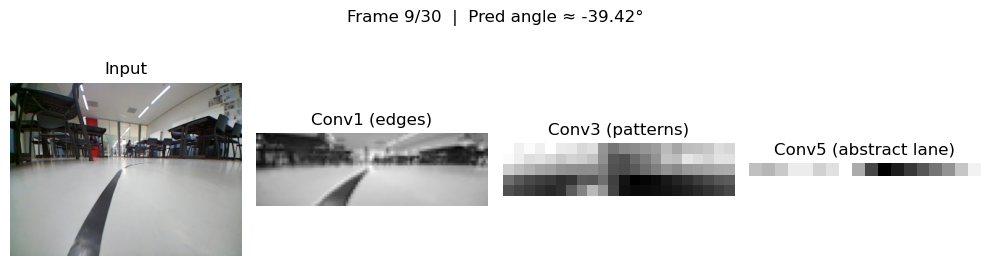

<Figure size 640x480 with 0 Axes>

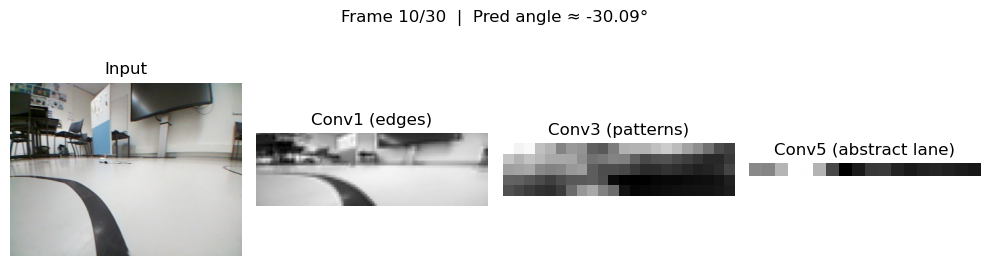

<Figure size 640x480 with 0 Axes>

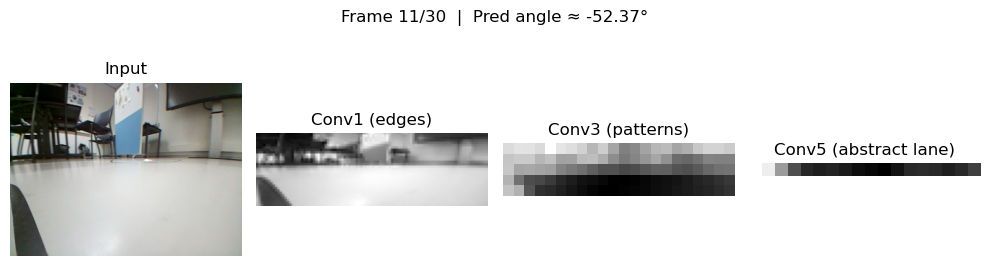

<Figure size 640x480 with 0 Axes>

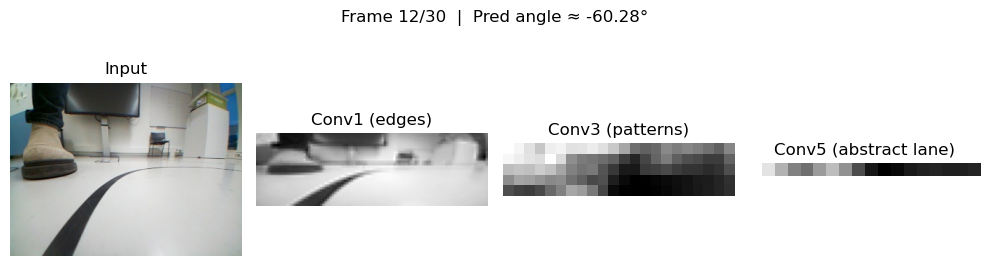

<Figure size 640x480 with 0 Axes>

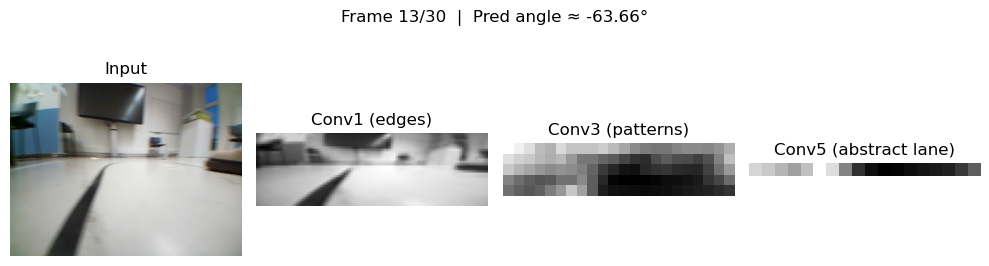

<Figure size 640x480 with 0 Axes>

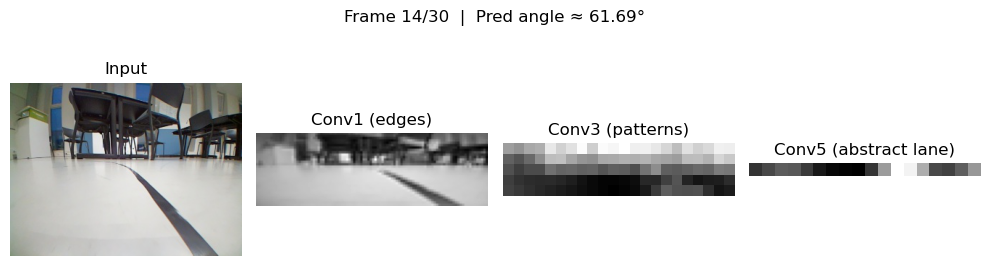

<Figure size 640x480 with 0 Axes>

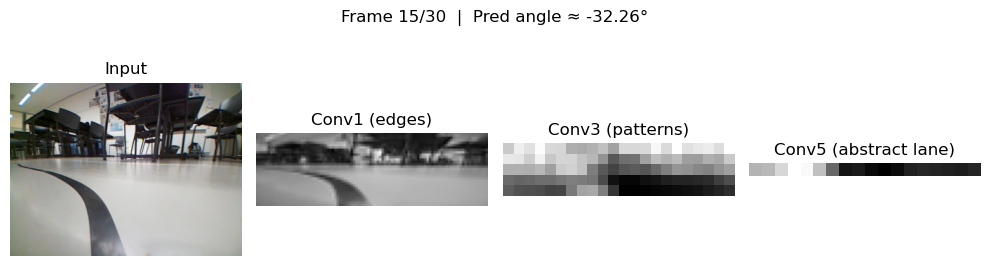

<Figure size 640x480 with 0 Axes>

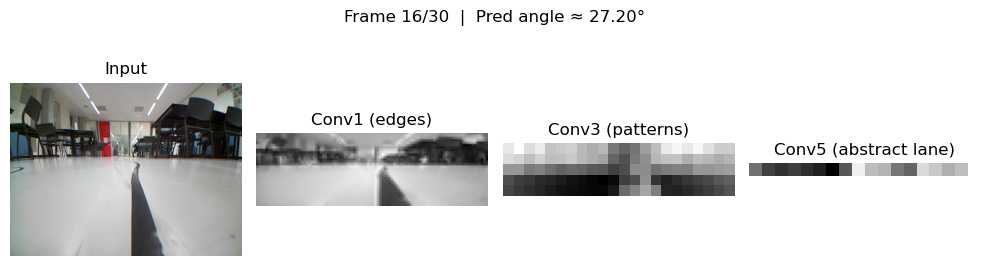

<Figure size 640x480 with 0 Axes>

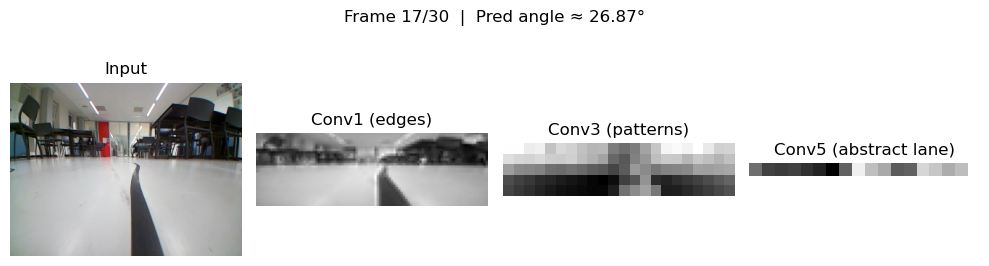

<Figure size 640x480 with 0 Axes>

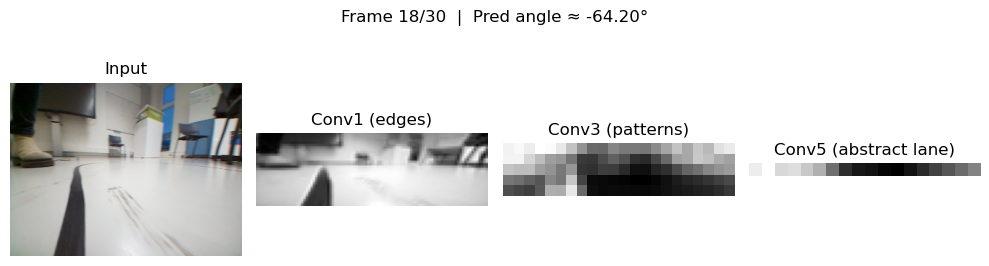

<Figure size 640x480 with 0 Axes>

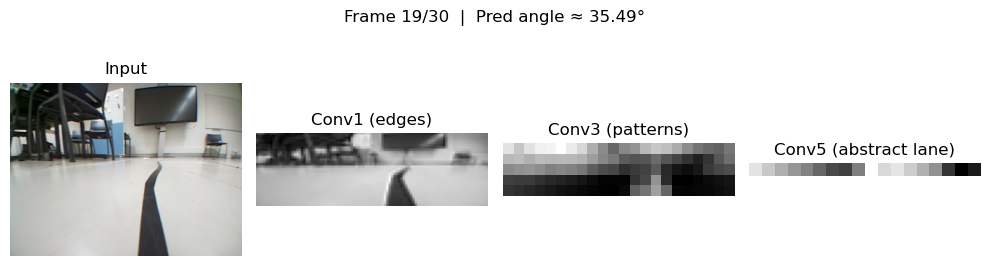

<Figure size 640x480 with 0 Axes>

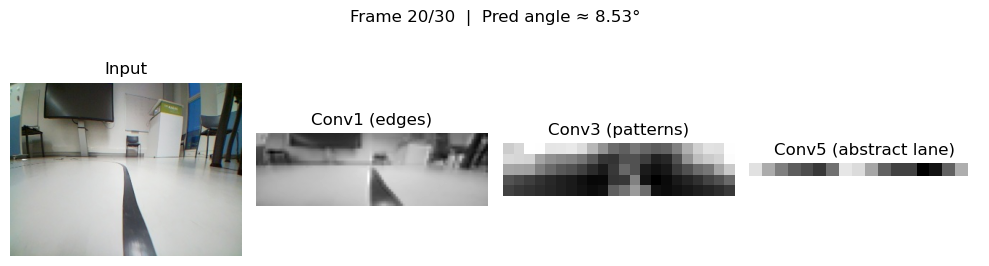

<Figure size 640x480 with 0 Axes>

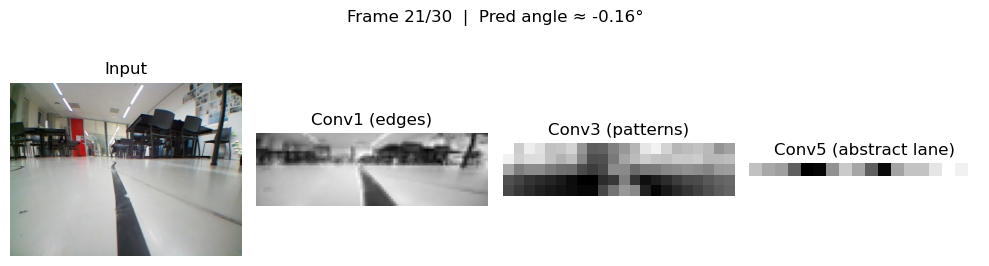

<Figure size 640x480 with 0 Axes>

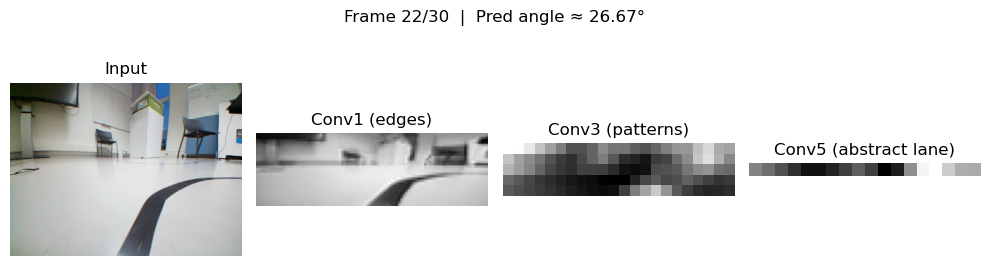

<Figure size 640x480 with 0 Axes>

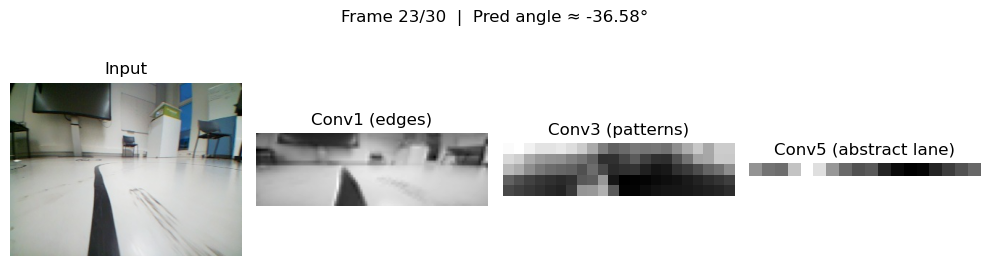

<Figure size 640x480 with 0 Axes>

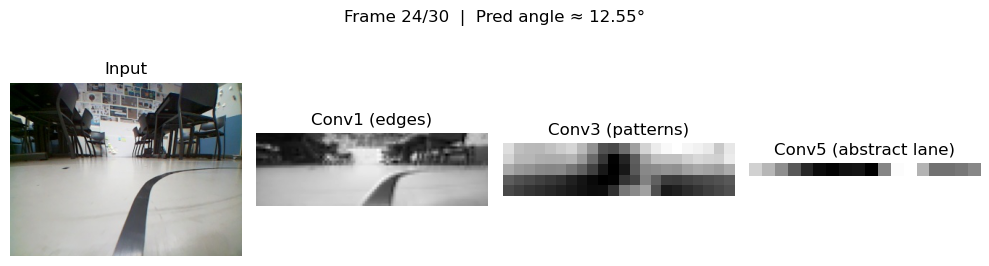

<Figure size 640x480 with 0 Axes>

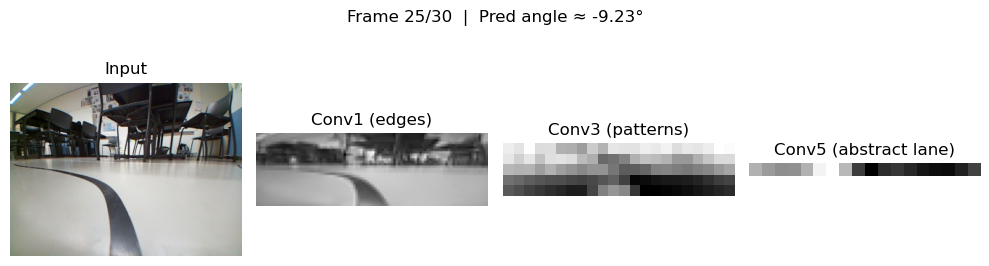

<Figure size 640x480 with 0 Axes>

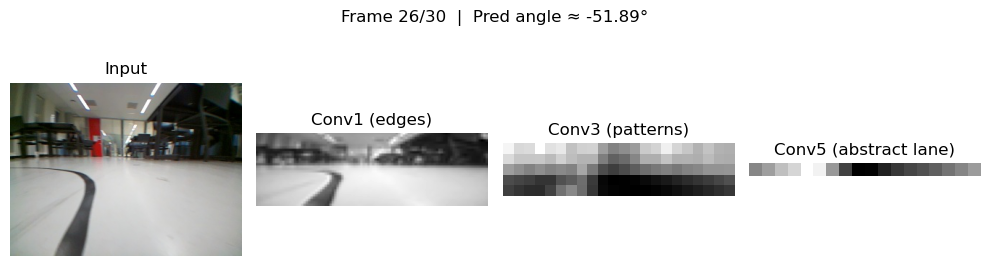

<Figure size 640x480 with 0 Axes>

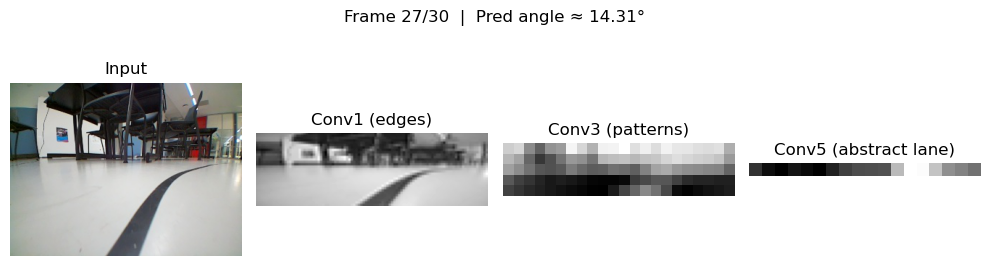

<Figure size 640x480 with 0 Axes>

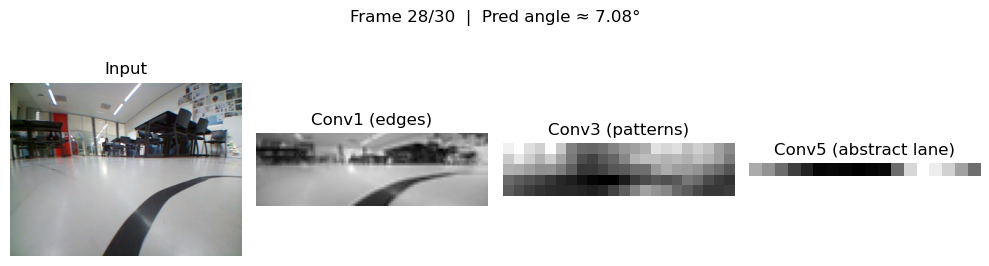

<Figure size 640x480 with 0 Axes>

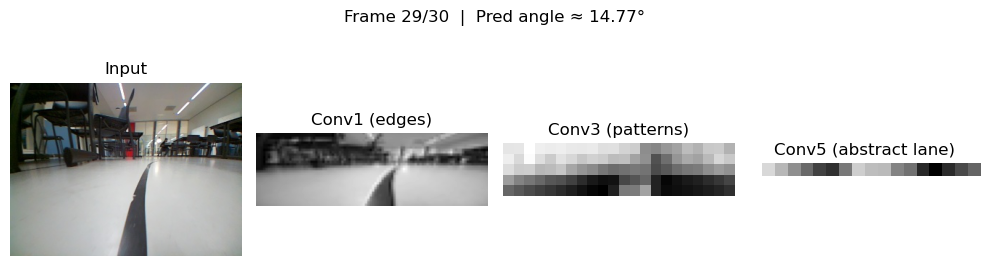

<Figure size 640x480 with 0 Axes>

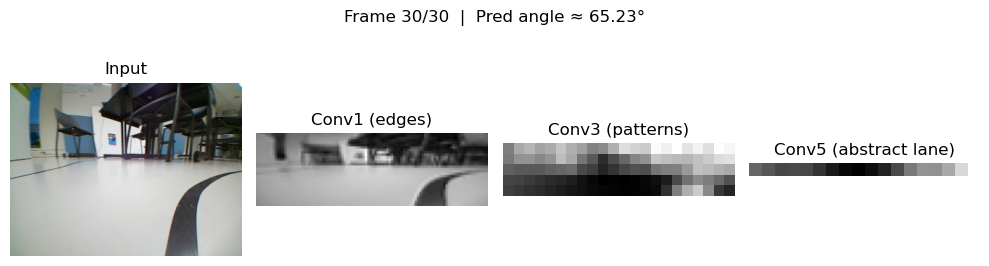

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Make sure model is on DEVICE and val_transform is defined
model.eval()

# Indices of the Conv2d layers inside model.conv (as before)
conv_indices = [0, 2, 4, 6, 8]
conv_names   = ["conv1", "conv2", "conv3", "conv4", "conv5"]

def get_activation_dict():
    activations = {}
    def make_hook(name):
        def hook(m, inp, out):
            activations[name] = out.detach().cpu()
        return hook

    # register hooks
    handles = []
    for idx, name in zip(conv_indices, conv_names):
        h = model.conv[idx].register_forward_hook(make_hook(name))
        handles.append(h)
    return activations, handles

# pick N random validation images to simulate a "run"
N_FRAMES = 30
rows = val_df.sample(N_FRAMES, random_state=42)

plt.ion()  # interactive mode on

activations, handles = get_activation_dict()

for i, (_, row) in enumerate(rows.iterrows()):
    img_path = os.path.join(IMAGE_DIR, row[FILENAME_COL])
    img_pil = Image.open(img_path).convert("RGB")

    # preprocess like validation
    x = val_transform(img_pil).unsqueeze(0).to(DEVICE)

    # forward pass (fills activations)
    with torch.no_grad():
        y_norm = model(x).item()

    # denormalize angle
    angle_deg = y_norm * max_abs_angle

    # get some feature maps (first channel from some layers)
    conv1_map = activations["conv1"][0, 0].numpy()        # [H,W]
    conv3_map = activations["conv3"][0, 0].numpy()
    conv5_map = activations["conv5"][0, 0].numpy()

    # plot
    plt.figure(figsize=(10, 3))
    plt.suptitle(f"Frame {i+1}/{N_FRAMES}  |  Pred angle ≈ {angle_deg:.2f}°")

    # original image
    plt.subplot(1, 4, 1)
    plt.imshow(img_pil)
    plt.title("Input")
    plt.axis("off")

    # early layer
    plt.subplot(1, 4, 2)
    plt.imshow(conv1_map, cmap="gray")
    plt.title("Conv1 (edges)")
    plt.axis("off")

    # middle layer
    plt.subplot(1, 4, 3)
    plt.imshow(conv3_map, cmap="gray")
    plt.title("Conv3 (patterns)")
    plt.axis("off")

    # deep layer
    plt.subplot(1, 4, 4)
    plt.imshow(conv5_map, cmap="gray")
    plt.title("Conv5 (abstract lane)")
    plt.axis("off")

    plt.tight_layout()
    plt.pause(0.4)   # pause so you can see it "live"
    plt.clf()

plt.ioff()

# remove hooks
for h in handles:
    h.remove()
plt.close("all")


In [29]:
import torch

MODEL_PATH = "model_weights2.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "max_abs_angle": max_abs_angle,
}, MODEL_PATH)

print("Saved model to:", MODEL_PATH)


Saved model to: model_weights2.pth
